In [51]:
# Risk_Rent_Buy housing analysis Project
# This project analyzes housing data in US counties, including rent prices, purchase prices, and risk scores.
# normalize data, calculate costom indices, vizualize on a map, and apply linear regression to understand correlations.

In [52]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [53]:
# Load main housing risk dataset and coordinates dataset
df = pd.read_csv("housing_risk.csv")
coords = pd.read_csv("us_county_latlng.csv")

# Clean and normalize county and state names
df["county_clean"] = df["County"].astype(str).str.strip().str.lower()
df["state_clean"] = df["StateName"].astype(str).str.strip().str.lower()
coords["name_clean"] = coords["name"].astype(str).str.strip().str.lower()
coords["fips_code"] = coords["fips_code"].astype(str).str.zfill(5)

# Merge coordinates into main DataFrame using cleaned county name
df = df.merge(coords[["fips_code", "name_clean", "lat", "lng"]],
              left_on="county_clean", right_on="name_clean", how="left")

In [54]:
# Drop rows with missing values for key columns
df = df.dropna(subset=["PurchasePrice", "RentPrice", "RiskScore"])

# Normalize numerical columns using Min, Max scaling
scaler = MinMaxScaler()
norm = scaler.fit_transform(df[["PurchasePrice", "RentPrice", "RiskScore"]])
df[["PurchaseNorm", "RentNorm", "RiskNorm"]] = pd.DataFrame(norm)

# Create composite indices for buying and renting
df["BuyIndex"] = df["PurchaseNorm"] + df["RiskNorm"]
df["RentIndex"] = df["RentNorm"] + df["RiskNorm"]

In [55]:
# Select top 50 counties for each category
top_buy = df.sort_values("BuyIndex").head(50)
top_rent = df.sort_values("RentIndex").head(50)
top_risk = df.sort_values("RiskScore", ascending=False).head(50)

In [56]:
# Function to add points to a Folium map
def add_points(data, color, label, index_column):
    for _, row in data.iterrows():
        if pd.notna(row["lat"]) and pd.notna(row["lng"]):
            popup = (f"<b>{row["County"].title()}</b>, {row["StateName"].upper()}<br>"
                     f"<b>{label}:</b> {row[index_column]:.2f}")
            folium.CircleMarker(
                location=[row["lat"], row["lng"]],
                radius=6,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.85,
                popup=popup
            ).add_to(m)

# Create base map centered on the US
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add points to map for rent, buy and risk
add_points(top_rent, "green", "RentPrice", "RentPrice")
add_points(top_buy, "blue", "PurchasePrice", "PurchasePrice")
add_points(top_risk, "red", "RiskScore", "RiskScore")

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m

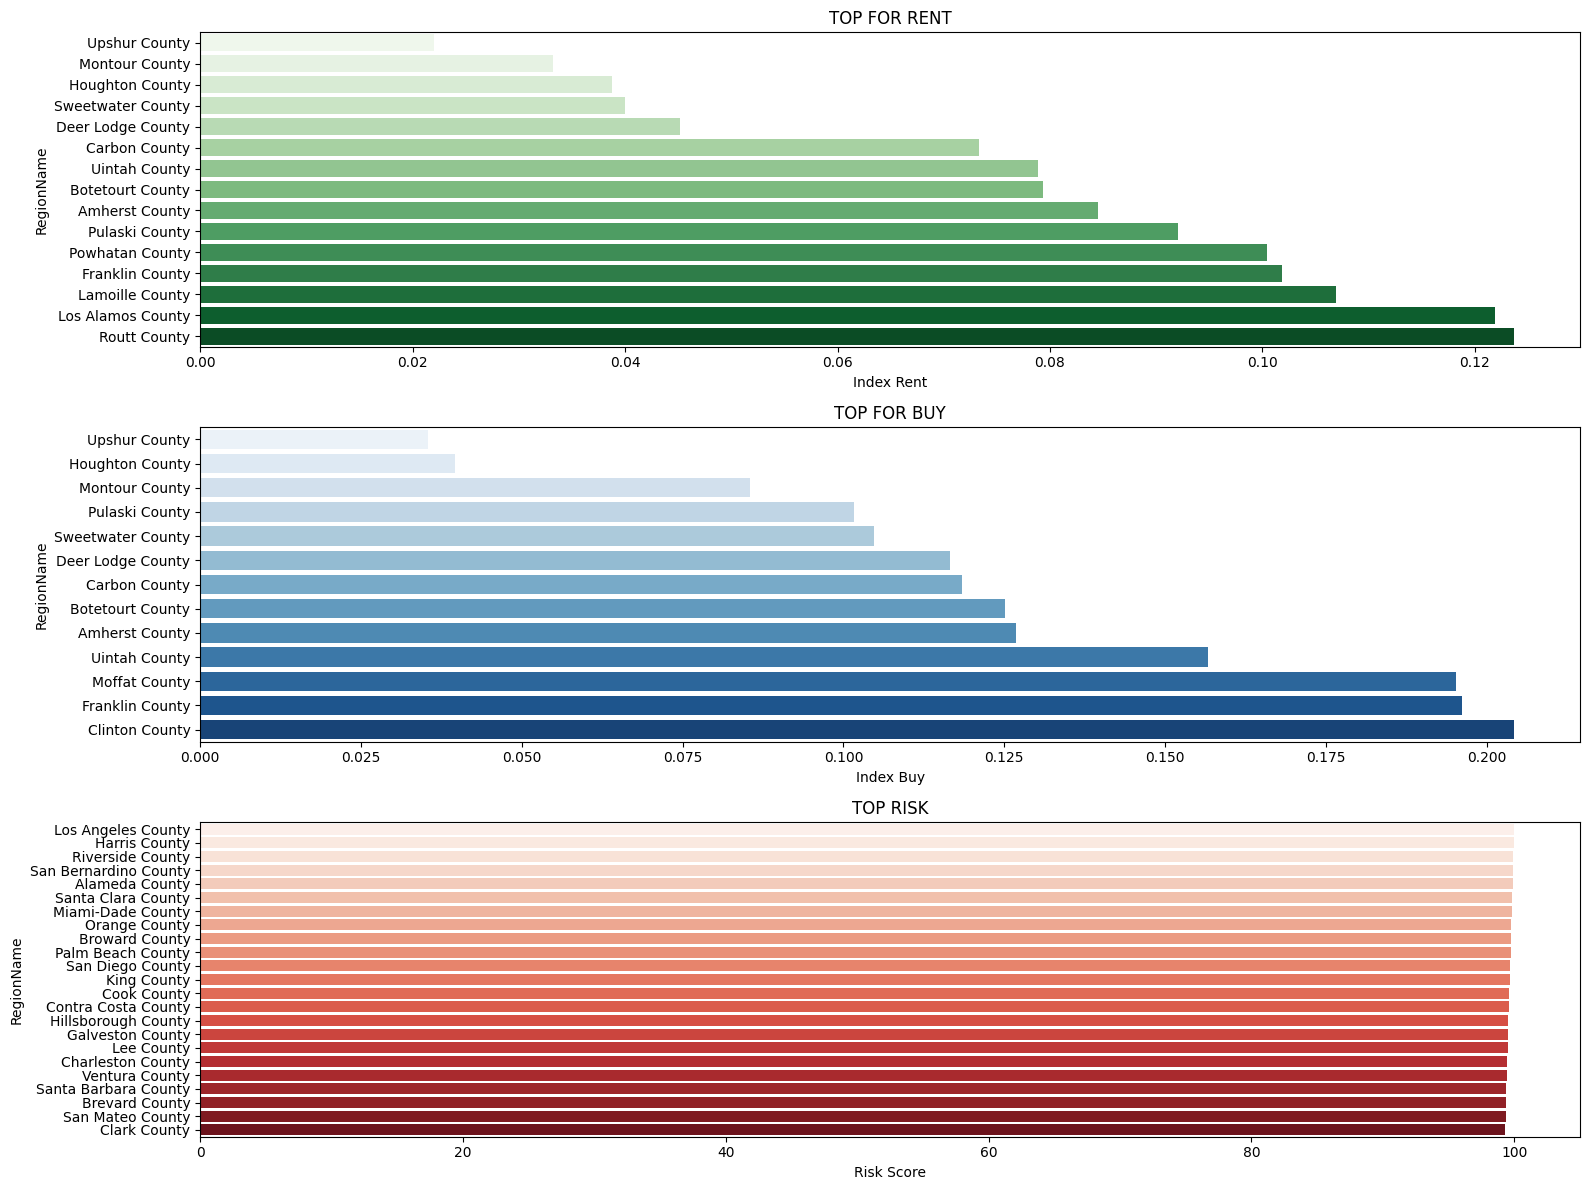

In [57]:
# Creat bar plots for best counties in rent , buy and risk

plt.figure(figsize=(16, 12))

# Rent
plt.subplot(3, 1, 1)
sns.barplot(x="RentIndex", y="RegionName", data=top_rent, hue="RegionName", dodge=False, palette="Greens")
plt.title("TOP FOR RENT")
plt.xlabel("Index Rent")

# Buy
plt.subplot(3, 1, 2)
sns.barplot(x="BuyIndex", y="RegionName", data=top_buy, hue="RegionName", dodge=False, palette="Blues")
plt.title("TOP FOR BUY")
plt.xlabel("Index Buy")

# Risk
plt.subplot(3, 1, 3)
sns.barplot(x="RiskScore", y="RegionName", data=top_risk, hue="RegionName", dodge=False, palette="Reds")
plt.title("TOP RISK")
plt.xlabel("Risk Score")

plt.tight_layout()
plt.show()

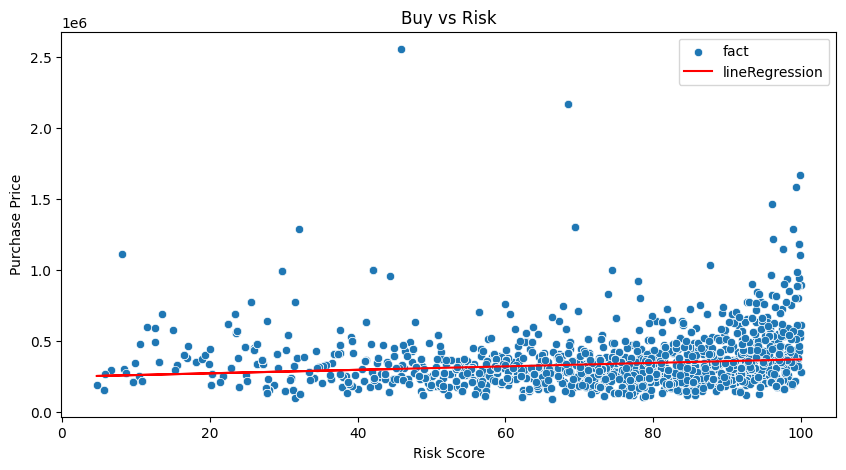

In [58]:
# Linear regression: RiskScoree vs PurchasePrice
x = df[["RiskScore"]]
y = df["PurchasePrice"]
model = LinearRegression()
model.fit(x, y)
df["PredictedPurchase"] = model.predict(x)

plt.figure(figsize=(10, 5))
sns.scatterplot(x="RiskScore", y="PurchasePrice", data=df, label="fact")
plt.plot(df["RiskScore"], df["PredictedPurchase"], color="red", label="lineRegression")
plt.title("Buy vs Risk")
plt.xlabel("Risk Score")
plt.ylabel("Purchase Price")
plt.legend()
plt.show()

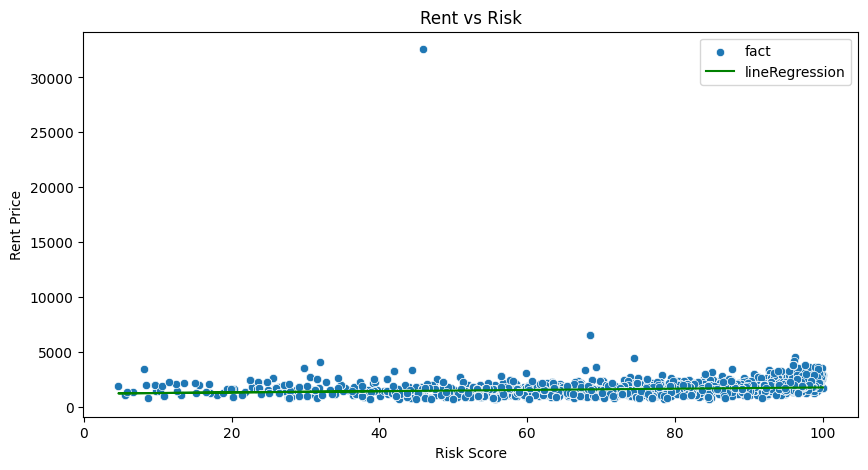

In [59]:
# Linear regression: RiskScore vs RentPrice
x = df[["RiskScore"]]
y = df["RentPrice"]
model = LinearRegression()
model.fit(x, y)
df["PredictedRent"] = model.predict(x)

plt.figure(figsize=(10, 5))
sns.scatterplot(x="RiskScore", y="RentPrice", data=df, label="fact")
plt.plot(df["RiskScore"], df["PredictedRent"], color="green", label="lineRegression")
plt.title("Rent vs Risk")
plt.xlabel("Risk Score")
plt.ylabel("Rent Price")
plt.legend()
plt.show()

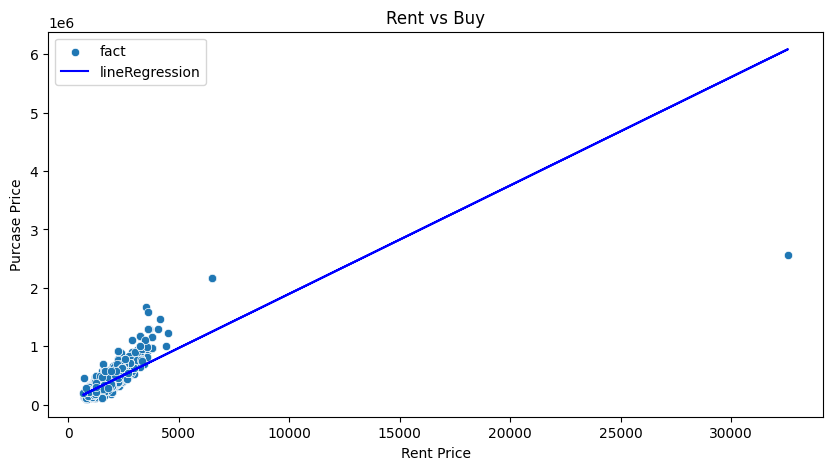

In [60]:
#Linear regression: RentPrice vs PurchasePrice
x = df[["RentPrice"]]
y = df["PurchasePrice"]
model = LinearRegression()
model.fit(x, y)
df["PredictedBuyFromRent"] = model.predict(x)

plt.figure(figsize=(10, 5))
sns.scatterplot(x="RentPrice", y="PurchasePrice", data=df, label="fact")
plt.plot(df["RentPrice"], df["PredictedBuyFromRent"], color="blue", label="lineRegression")
plt.title("Rent vs Buy")
plt.xlabel("Rent Price")
plt.ylabel("Purcase Price")
plt.legend()
plt.show()

In [61]:
df.to_csv("final_risk_rent_buy_housing_analysis.csv", index=False)